<a href="https://colab.research.google.com/github/feliciahf/data_science_exam/blob/main/hippocorpus_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import keras
import matplotlib.pyplot as plt

# Import data

In [2]:
# import csv file as dataframe (from GitHub repo)
url = 'https://raw.githubusercontent.com/feliciahf/data_science_exam/main/hippoCorpusV2.csv'
df = pd.read_csv(url, encoding='latin1')

In [3]:
# remove columns with uninformative information (AssignmentId, WorkerId, recAgnPairId, recImgPairId)
uninformative_cols = ["AssignmentId", "WorkerId", "recAgnPairId", "recImgPairId"]
df = df.drop(columns=uninformative_cols)

In [4]:
# make labels column using numerical values
df.memType = pd.Categorical(df.memType)
df['label'] = df.memType.cat.codes

In [5]:
# story type corresponding to label
print(f"Label 0: {df.loc[df['label'] == 0,'memType'].unique()}")
print(f"Label 1: {df.loc[df['label'] == 1,'memType'].unique()}")
print(f"Label 2: {df.loc[df['label'] == 2,'memType'].unique()}")

Label 0: ['imagined']
Categories (1, object): ['imagined']
Label 1: ['recalled']
Categories (1, object): ['recalled']
Label 2: ['retold']
Categories (1, object): ['retold']


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6854 entries, 0 to 6853
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   WorkTimeInSeconds  6854 non-null   int64   
 1   annotatorAge       6831 non-null   float64 
 2   annotatorGender    6854 non-null   object  
 3   annotatorRace      6854 non-null   object  
 4   distracted         6854 non-null   float64 
 5   draining           6854 non-null   float64 
 6   frequency          4098 non-null   float64 
 7   importance         6710 non-null   float64 
 8   logTimeSinceEvent  6854 non-null   float64 
 9   mainEvent          6854 non-null   object  
 10  memType            6854 non-null   category
 11  mostSurprising     6854 non-null   object  
 12  openness           6854 non-null   float64 
 13  similarity         2756 non-null   float64 
 14  similarityReason   2756 non-null   object  
 15  story              6854 non-null   object  
 16  stress

In [8]:
df.memType.value_counts()

recalled    2779
imagined    2756
retold      1319
Name: memType, dtype: int64

In [9]:
def print_plot(index):
    example = df[df.index == index][['story', 'memType']].values[0]
    if len(example) > 0:
        print(example[0])
        print('memType:', example[1])
print_plot(10)

About a month ago me and my girlfriend went to the zoo. It was an unexpected trip we just decided to go on a random Wednesday. It was a pretty hot day that day considering it was the middle of July. As soon as we got in, we saw that there were some seals to the left of the entrance so we saw them for a few minutes. Then we went to the insect section of the zoo. There were so many of them like spiders, scorpions, also bigger animals like cobras, rattlesnakes stuff like that. Then we saw the elephants. It was pretty interesting because they were in an area that looked like a jungle and off in the distance we heard gorillas grunting. So we walked around until we found the gorillas and around there we also saw other kinds of primates like chimpanzees. We walked around a bit more and we stumbled upon all the other African animals like tigers, lions, giraffes etc. It was actually pretty cool to see the giraffes because one of them got really close to me. Along the way we saw a lot of differe

# Preprocessing

In [19]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['story'] = df['story'].apply(clean_text)
df['story'] = df['story'].str.replace('\d+', '')

In [20]:
df['story']

0       concerts favorite thing boyfriend knew thats a...
1       day started perfectly great drive denver show ...
2       seems like yesterday today makes five months a...
3       five months ago niece nephew born sisters firs...
4       month ago went burning man hard time life felt...
                              ...                        
6849    dog diagnosed lymphoma year ago chemotherapy r...
6850    vacation job went casper took side job lasted ...
6851    event birthday party nephew turned five gather...
6852    event occurred two weeks ago going shopping bi...
6853    past year involved court situation involving d...
Name: story, Length: 6854, dtype: object

In [21]:
print_plot(10)

month ago girlfriend went zoo unepected trip decided go random wednesday pretty hot day day considering middle july soon got saw seals left entrance saw minutes went insect section zoo many like spiders scorpions also bigger animals like cobras rattlesnakes stuff like saw elephants pretty interesting area looked like jungle distance heard gorillas grunting walked around found gorillas around also saw kinds primates like chimpanzees walked around bit stumbled upon african animals like tigers lions giraffes etc actually pretty cool see giraffes one got really close along way saw lot different kinds birds small animals passed koalas australian animals like tasmanian devils kangaroos would enjoyed though gone another day really hot day didnt really prepare really enjoyed going well probably go soon
memType: recalled


In [85]:
# The maximum number of words to be used (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each story
MAX_SEQUENCE_LENGTH = 1967
# This is fixed
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['story'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 26593 unique tokens.


In [86]:
X = tokenizer.texts_to_sequences(df['story'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (6854, 1967)


In [87]:
# change categorical strings to values
Y = pd.get_dummies(df['memType']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (6854, 3)


# Split dataset

In [88]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(5483, 1967) (5483, 3)
(1371, 1967) (1371, 3)


# LSTM Model

In [102]:
model = keras.Sequential()
model.add(keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(keras.layers.SpatialDropout1D(0.2))
model.add(keras.layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(keras.layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 2
batch_size = 32

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/2
35/35 [==============================] - 225s 6s/step - loss: 1.0806 - accuracy: 0.3913 - val_loss: 1.0550 - val_accuracy: 0.4622
Epoch 2/2
35/35 [==============================] - 211s 6s/step - loss: 1.0326 - accuracy: 0.5420 - val_loss: 1.2172 - val_accuracy: 0.4066


# Model evaluation

In [103]:
# model evaluation
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

43/43 [==============================] - 14s 336ms/step - loss: 1.1843 - accuracy: 0.4311
Test set
  Loss: 1.184
  Accuracy: 0.431


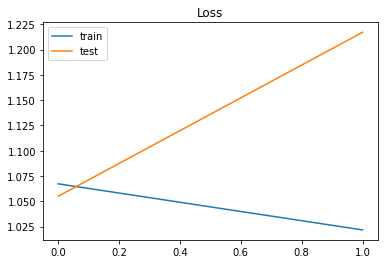

In [104]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

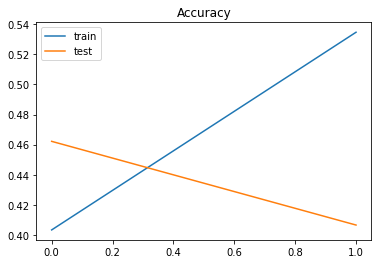

In [105]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();